# Datset: Pairwise approach

Get tracksters from a certain neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - figure out how these links are formed
- convert the tracksters into some latent space and predict a link between them
- later extend this using edgeconv or sageconf to add information from the neighbourhood

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


In [4]:
import uproot
import torch
import random
import numpy as np

from reco.distance import euclidian_distance
from reco.matching import find_good_pairs
from reco.dataset import match_trackster_pairs, TracksterPairs
from reco.plotting import plot_tracksters
from reco.event import get_bary

import matplotlib.pyplot as plt

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = "/mnt/ceph/users/ecuba/multiparticle_10/"

data_root = "data/"
raw_dir = "/Users/ecuba/data/multiparticle_complet"

file_name = f"{raw_dir}/new_ntuples_14992862_2791.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})
graph = uproot.open({file_name: "ticlNtuplizer/graph"})

In [2]:
eid = 10

# prepare distance points
vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
ve = tracksters["vertices_energy"].array()[eid]
clouds = [np.array([vx[tid], vy[tid], vz[tid]]).T for tid in range(len(vx))]

## Candidate pairs

Compile a list of candidate pairs based on the CLUE3D graph and node distance.

Reject all nodes with above a distance threshold.

In [3]:
MAX_DISTANCE = 20   # cm

candidate_pairs = []
distances = []

inners_list = graph["linked_inners"].array()[eid]
for i, inners in enumerate(inners_list):
    for inner in inners:
        dst = euclidian_distance(clouds[i], clouds[inner])
        distances.append(dst)
        if dst <= MAX_DISTANCE:
            candidate_pairs.append((i, inner))
            
print("Candidate pairs:", len(candidate_pairs))

Candidate pairs: 768


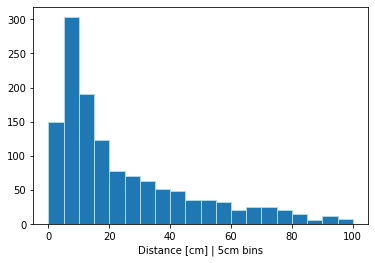

In [4]:
plt.hist(distances, bins=20, edgecolor="lightblue", range=(0, 100))
plt.xlabel("Distance [cm] | 5cm bins")
plt.show()

## Ground truth

In [5]:
gt_pairs = match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    distance_threshold=MAX_DISTANCE,
)
print("Ground truth pairs:", len(gt_pairs))

Ground truth pairs: 98


In [6]:
# sanity check
# all gold pairs are present in the candidate pairs

ab_pairs = set([(a, b) for a, b, _ in gt_pairs])
ba_pairs = set([(b, a) for a, b, _ in gt_pairs])
c_pairs = set(candidate_pairs)

matches = ab_pairs.union(ba_pairs).intersection(c_pairs)
not_matches = c_pairs - matches

# edges that are not the best but still correct
neutral = find_good_pairs(tracksters, associations, not_matches, eid)
positive = list(matches)
negative = random.sample(list(not_matches-neutral), k=len(matches))

print(f"positive: {len(positive)} negative: {len(not_matches)} negative selected: {len(set(negative))} neutral: {len(neutral)}")
# assert len(matches) == len(gt_pairs)

positive: 91 negative: 677 negative selected: 91 neutral: 12


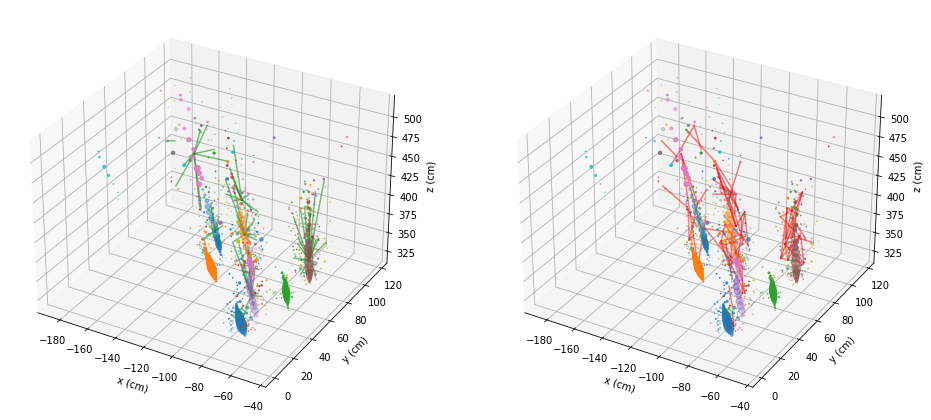

In [7]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plot_tracksters(ax1, vx, vy, vz, ve)
plot_tracksters(ax2, vx, vy, vz, ve)
bary = get_bary(tracksters, eid)

def plot_edge(ax, edge, color):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(x, y, z, c=color, alpha=0.5)

for edge in positive:
    plot_edge(ax1, edge, "green")

for edge in negative:
    plot_edge(ax2, edge, "red")

plt.show()

## Dataset

In [8]:
ds = TracksterPairs(
    "10p_multi",
    data_root,
    raw_dir,
    N_FILES=10,
    balanced=False,
    include_neutral=False,
    MAX_DISTANCE=15,
    ENERGY_THRESHOLD=20
)
ds

Processing: /Users/ecuba/data/multiparticle_complet/new_ntuples_14992862_2834.root
Processing: /Users/ecuba/data/multiparticle_complet/new_ntuples_14992862_542.root
Processing: /Users/ecuba/data/multiparticle_complet/new_ntuples_14992862_112.root
Processing: /Users/ecuba/data/multiparticle_complet/new_ntuples_14992862_2137.root
Processing: /Users/ecuba/data/multiparticle_complet/new_ntuples_14992862_10.root
Processing: /Users/ecuba/data/multiparticle_complet/new_ntuples_14992862_2567.root
Processing: /Users/ecuba/data/multiparticle_complet/new_ntuples_14992862_2588.root
Processing: /Users/ecuba/data/multiparticle_complet/new_ntuples_14992862_2072.root
Processing: /Users/ecuba/data/multiparticle_complet/new_ntuples_14992862_954.root
Processing: /Users/ecuba/data/multiparticle_complet/new_ntuples_14992862_2422.root


<TracksterPairs len=77245 balanced=False max_distance=15 energy_threshold=20>

In [9]:
ds[0]

(tensor([ 2.8840e+01, -7.7948e+01,  3.7719e+02,  5.7066e+00,  2.5085e-01,
          1.9967e+02,  3.2108e+00,  7.9126e-01,  1.5763e-01, -1.8198e-01,
          9.7058e-01,  1.2722e+01,  6.0647e+00,  2.2442e+00,  3.4111e+01,
         -7.7719e+01,  3.6283e+02,  4.3362e+01,  2.6596e+01,  3.6788e+01,
          9.3066e-01,  1.7068e-01,  9.6874e-02, -2.1366e-01,  9.7209e-01,
          5.6896e+00,  2.2278e+00,  7.4496e-01,  4.9191e+00,  1.4000e+01,
          1.8000e+01,  3.5714e+00,  2.2384e+02,  1.2831e+01,  2.7473e-01,
          5.5612e-01,  3.0000e+00,  3.6667e+00,  1.3062e+02,  6.6441e+01,
          2.1569e-01,  6.5582e-01,  3.0000e+00]),
 tensor(1.))

## Dummy evaluation

Let's talk baselines on this dataset. How good is a random guess?
How good is connecting to all nodes in a neighbourhood?

In [1]:
from reco.evaluation import pairwise_model_evaluation

In [2]:
class DummyModel:
    def eval(self):
        pass

class DummyPleaser(DummyModel):
    def __call__(self, X):
        return torch.tensor(np.ones(len(X)))

class DummyGuesser(DummyModel):
    def __call__(self, X):
        return torch.tensor(np.random.random(len(X)))

class DummyScaler:
    def transform(self, X):
        return X.tolist()

In [5]:
result = pairwise_model_evaluation(
    tracksters,
    simtracksters,
    associations,
    graph,
    DummyPleaser(),
    DummyScaler(),
    0.5,
    max_distance=15,
    energy_threshold=20,
    max_events=5,
)

Event 0:
	clue3d_to_sim:	P: 0.96 R: 0.31 F: 0.36
	target_to_sim:	P: 0.97 R: 0.64 F: 0.68
	reco_to_target:	P: 0.90 R: 0.88 F: 0.88
	reco_to_sim:	P: 0.95 R: 0.60 F: 0.64
Event 1:
	clue3d_to_sim:	P: 0.96 R: 0.46 F: 0.51
	target_to_sim:	P: 0.97 R: 0.81 F: 0.84
	reco_to_target:	P: 0.80 R: 0.79 F: 0.79
	reco_to_sim:	P: 0.90 R: 0.69 F: 0.73
Event 2:
	clue3d_to_sim:	P: 0.98 R: 0.30 F: 0.35
	target_to_sim:	P: 0.98 R: 0.65 F: 0.70
	reco_to_target:	P: 0.86 R: 0.83 F: 0.84
	reco_to_sim:	P: 0.96 R: 0.62 F: 0.66
Event 3:
	clue3d_to_sim:	P: 0.99 R: 0.51 F: 0.57
	target_to_sim:	P: 0.99 R: 0.86 F: 0.89
	reco_to_target:	P: 0.85 R: 0.79 F: 0.80
	reco_to_sim:	P: 0.93 R: 0.71 F: 0.75
Event 4:
	clue3d_to_sim:	P: 0.95 R: 0.18 F: 0.21
	target_to_sim:	P: 0.96 R: 0.44 F: 0.49
	reco_to_target:	P: 0.74 R: 0.68 F: 0.69
	reco_to_sim:	P: 0.88 R: 0.36 F: 0.41
----------
mean clue3d_to_sim:	P: 0.97 R: 0.35 F: 0.40
mean target_to_sim:	P: 0.97 R: 0.68 F: 0.72
mean reco_to_target:	P: 0.83 R: 0.79 F: 0.80
mean reco_to_sim